# Interpretable Machine Learning Python Activity

 - Weiwen Nie (weiwennie1960@gmail.com)
 - Ivan Hernandez (ivanhernandez@vt.edu)

# 0. Load packages

The first step will be leading the required python packages to:
 - perform numeric calculations (numpy)
 - handle reading in data (pandas)
 - plot figures (matplotlib.pyplot)
 - preprocess, train, and evaluate a model (sklearn)
 - correct for imblanced outcomes (imblearn)
 - train an extreme gradient boosted tree machine learning models (xgboost)
 - view the SHAP values of a model(shap)

In [4]:
#You may not have sklearn, imblearn, xgboost, or shap installed. You can install them, but running the following lines
#import sys
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install imblearn
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install shap

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline



from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report)

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap

# 1. Read in the Data

We will read in the tab separated data file "IBM_hr_attrition.csv" as a pandas dataframe. 

The file is saved in the same directory as this notebook.

We will call the pandas dataframe variable, "attrition" because that is the outcome we are going to try to predict and explain


#### Note. The dataset used for the demonstration is from https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset 

#### Note. The data exploration of the current dataset can go to the following kernal on Kaggle 

https://www.kaggle.com/arthurtok/employee-attrition-via-ensemble-tree-based-methods

In [6]:
attrition = pd.read_csv('C:/Users/blah/Documents/pythone_dataset/IBM_hr_attrition.csv', sep = '\t')

# 2. Data cleaning and preparing 

The following steps perform common procedures to transform a dataset into a set of numeric formatted predictors and outcomes

## Categorical encoding

The follow code checks the format of the variable in the pandas dataframe.

If the variable has a dtyle of "object" then we will append the column name to a list of categorical variables.

Every variable not in the categorical list, is considered a numeric variable

In [7]:
# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

## Dummy code the categorical predictor

For all of the categorical variables, except the outcome variable, we will create a new variable called, "attrition_cat" that contains the dummy coded items

In [8]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = attrition[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column

attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)

BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
0                          0                                 0   
1                          0                                 1   
2                          0                                 0   

   BusinessTravel_Travel_Rarely  Department_Human Resources  \
0                             1                           0   
1                             0                           0   
2                             1                           0   

   Department_Research & Development  Department_Sales  \
0                                  0                 1   
1                                  1                 0   
2                                  1                 0   

   EducationField_Human Resources  EducationField_Life Sciences  \
0                               0                             1   
1                               0                             1   
2                               0                             0   

   EducationField_Marketing  EducationField_Medical  ...  \
0                         0                       0  ...   
1                         0                       0  ...   
2                         0                       0  ...   

   JobRole_Research Director  JobRole_Research Scientist  \
0                          0                           0   
1                          0                           1   
2                          0                           0   

   JobRole_Sales Executive  JobRole_Sales Representative  \
0                        1                             0   
1                        0                             0   
2                        0                             0   

   MaritalStatus_Divorced  MaritalStatus_Married  MaritalStatus_Single  \
0                       0                      0                     1   
1                       0                      1                     0   
2                       0                      0                     1   

   Over18_Y  OverTime_No  OverTime_Yes  
0         1            0             1  
1         1            1             0  
2         1            0             1  

[3 rows x 29 columns]

## Creating new features from Numerical data and standardize it

For the numeric variables, we will standardized them by transforming them into Z-scores (mean = 0, std = 0, within each variable)

The Z-scored numeric variables are saved as a variable called "attribution_num"

In [9]:
# Store the numerical features to a dataframe attrition_num
attrition_num = attrition[numerical]

columns = attrition_num.columns

x = attrition_num.values #returns a numpy array
x_scaled = preprocessing.scale(x)
attrition_num = pd.DataFrame(x_scaled, columns = columns)

C:\Users\blah\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Concat numerical and categorical data togeter

We will combined the dummy coded categorical variables and the Z-scored numeric variables into a single dataset called, "attrition_final"

In [10]:
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)

## Recode outcome variable into 1 or 0

We will take the outcome variable, which is currently coded as "Yes" and "No", and recode it to be numbers, 1 (yes) and 0 (no)

In [11]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])
target.head(3)

0    1
1    0
2    1
Name: Attrition, dtype: int64

# Set the Predictor and the Outcome variables

We will take the combined predictor data and call it variable X

We will take the outcome variable, "atttrition" and call it variable y

In [12]:
X=attrition_final.as_matrix()
y=target.as_matrix()

C:\Users\blah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\blah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# 4. Split train test data

We will take the X and y variables, which represent the entire dataset and split them into a train and test dataset.

We will randomly sample 80% of the data to be the train, and the other 20% will be in the test dataset.

To ensure replicability, we set the random state to be deterministic (100)

To ensure that the proportions of "Yes" and "No" in the outcome are equal in the train and test sets, we stratify based on the target variable.

In [13]:
from sklearn.model_selection import train_test_split




# Split data into train and test sets as well as for validation and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size= 0.80,
                                                    random_state=100,
                                                    stratify = target)


C:\Users\blah\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Correct for Imbalanced Outcomes

Given that the target data is highly skewed (more than 90% of the outcomes are "No", meaning people stayed with the organization), we use the SMOTE method to oversample the data.

In [14]:
oversampler=SMOTE(random_state=101)
smote_train, smote_target = oversampler.fit_sample(X_train,y_train)

## 5. Fitting XGB Classifier to the train data

Next, we will fit an Extreme Gradient Boosted Tree to the data.

We define the classification model, and a list of potential hyperparameter combinations to try.

## Define estimator and param_grid 

In [15]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)

# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 1000],
        'learning_rate' : [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 7],
        'gamma': [0.1, 0.5, 1],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5, 12]
        }



## Hyper parameter tuning with randomsearch

To find a more optimal combination of hyperparameters, we search for 10 iterations by randomly selecting combinations of hyperparameters. Each combination of hyperparameters will evaluated with a 10-fold cross-validation. For each of those hyperparameter combinations, we save the average cross-validated error (AUC ROC) from the test folds of their cross-validation.

In [16]:
from sklearn.model_selection import RandomizedSearchCV


random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=3, scoring='roc_auc', n_jobs=3, cv=10, verbose=3, random_state=101)

random_search.fit(smote_train, smote_target)


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:   23.9s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=3, n_jobs=3,
          param_distributions={'n_estimators': [100, 200, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'min_child_weight': [1, 5, 7], 'gamma': [0.1, 0.5, 1], 'subsample': [0.6, 1.0], 'colsample_bytree': [0.6, 1.0], 'max_depth': [3, 5, 12]},
          pre_dispatch='2*n_jobs', random_state=101, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

## Hyperparameter search result

We can view the results to see what was the ideal combination of hyperparameter settings

In [17]:
print('\n XGB: Best roc-auc for %d-fold search with %d parameter combinations:' % (10, 100))
print(random_search.best_score_ )

print('\n XGB: Best hyperparameters:')
print(random_search.best_params_)


 XGB: Best roc-auc for 10-fold search with 100 parameter combinations:
0.9726975429670301

 XGB: Best hyperparameters:
{'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


## Fitting xgb model and to the test data and get performance report

Using the best extreme gradient boosting model from the randomized search, we will use that to fit our entire dataset.

In [20]:
# xgb 
xgb_clf = random_search.best_estimator_

xgb_clf.fit(smote_train, smote_target)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=12, min_child_weight=7, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)

We will then look a the performance of this model on the test dataset.

In [21]:
y_pred_x = xgb_clf.predict(X_test)
print("Test Accuracy score: {}".format(accuracy_score(y_test, y_pred_x)))
print("="*80)
print(classification_report(y_test, y_pred_x))

Test Accuracy score: 0.8741496598639455
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       247
           1       0.67      0.43      0.52        47

   micro avg       0.87      0.87      0.87       294
   macro avg       0.78      0.69      0.72       294
weighted avg       0.86      0.87      0.86       294



# 6. Interpret XGB model with Shap

Now that we have a trained model, we can interpet it using the SHAP package

We first need to load the javascript visualization code to view the figures in the notebook.

We then specify that we need a Tree explainer because we a tree-based machine learning model (xgboost)

Last, we provide our dataset of predictor variables to the explainer.

In [22]:
# load JS visualization code to notebook
shap.initjs()


# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(attrition_final)

## Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)

The base value suggest when no predictors invovle, the model have a bias output as 0.01927(log odd). 


From the first case, we can see the model identify the overtime_no = 1 and the overtime_yes=0 as the strongest drivers to drive the prediction toward turnover; on the other hand, the model also identify job satisfaction and Distance from home as the strongest drivers to drive the prediction toward stay. 

The final prediction of this case is -1.01(log odd). Predicting this case will stay. 


In [23]:
shap.force_plot(explainer.expected_value, shap_values[0,:], attrition_final.iloc[4,:])

## Visualize the training set predictions with the force plot

The force plot flips all the Shapley value from the plot above vertically and maps them in the same plot. 

The SHAP value is indicated on the Y axis and the number of cases are indicated on the X axis. 

We can view this force plot with similarity among cases, output value and other different views by toggling the bar on the top of the plot

In [24]:
shap.force_plot(explainer.expected_value, shap_values, attrition_final)

## Visualize the SHAP value with the summary plot

In this summary plot, the SHAP value and the feature value of every case represent a dot in the plot and all the cases are plot in each of the predictors. 

The feature value is represented with color spectrum and the SHAP value is represented with the placement of the dot for every case. 

This summary plot provides summary information on how the feature value related to the SHAP value in the model. 

For example, for the dichotomized variable OverTime_Yes , when it is one, it is more likely to have a positive SHAP value and when it is zero, it is more likely to have negative SHAP value. 

For example, for the continuous variable DistanceFromHome, the SHAP value increase as the variable increases. 

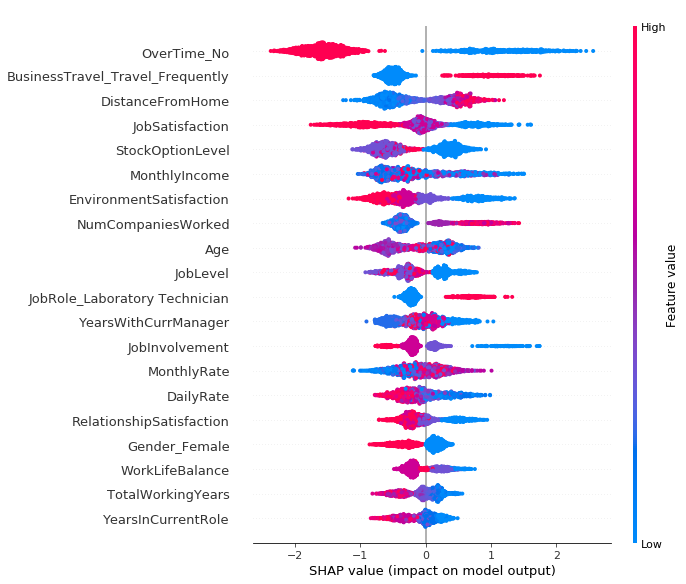

In [25]:
shap.summary_plot(shap_values, attrition_final)

## Visualize the absolute SHAP value summary plot to evaluate feature importance to the model

In this plot, we take the absoulate value of the SHAP value and then sum it up variable by variable. 

We can access the predictor importance to the model with this plot

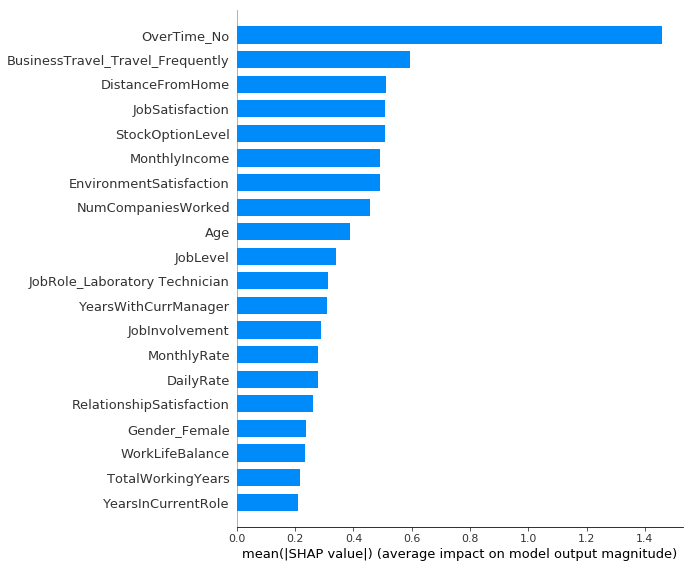

In [26]:
shap.summary_plot(shap_values, attrition_final, plot_type="bar")

# Visualize the dependency plot for a given variable 

We first create a dependency plot for OverTime_yes

Each dot in this plot represents the SHAP value for OverTime_yes for one case. 

The color spectrum represents the feature value of another feature (we normalized the YearAtCompany variable before we build the model). 

The selection of another feature is based on correlations of the SHAP value of OverTime_yes and the SHAP value of the rest of feature. The algorithm will select the feature that have the strongest correlation with the variable being plotted. The stong correlation between the SHAP values of two variables suggest these two variable likely interact with each other inside the model.  

From this dependency plot, we can see the YearAtCompany virable might interact with the OverTime_yes variable in a way that the longer the employees stay in the company, the lesser impact the variable Overtime_yes has on the turnover decision of the employees. (The range of the SHAP value is smaller for those cases have a larger feature value of YearsAtcompany.)


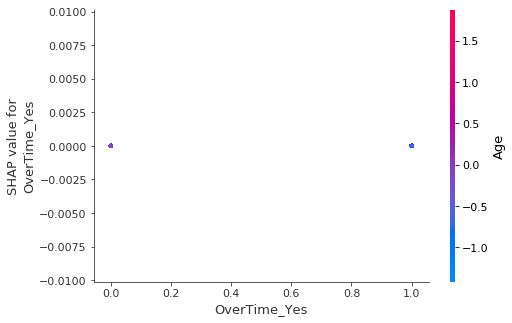

In [27]:
shap.dependence_plot("OverTime_Yes", shap_values, attrition_final)

From this dependency plot, we can see the Joblevel might interact with OverTime_No variable in a way that when JobLevel is higher, the impact of OverTime_No has weaker impact on turnover, and on the other hand when jobLevel is lower, the OverTime_no on turnover is stonger. This suggests, Employees who have lower job level are more sensitive to whehther they need to work over time and this factor has a strong impact on their turnover outcome. 

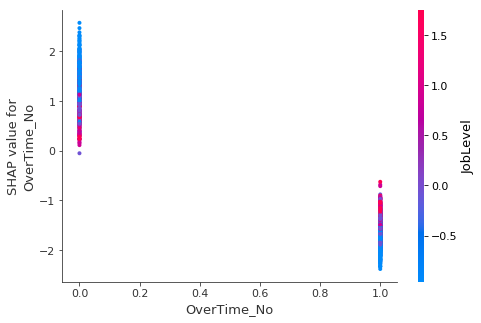

In [28]:
shap.dependence_plot("OverTime_No", shap_values, attrition_final)

From this dependency plot, we can see the DistanceFromHome variable might interact with StockOptionLevel variable in a way that when StockOptionLevel is higher, the impact of DistanceFromHome has weaker impact on turnover, and on the other hand when StockOptionLevel is lower, the DistanceFromHome on turnover is stonger. This suggests, Employees who have higher StockOptionLevel are less sensitive to they live far from the company and this factor has a relatively strong impact on their turnover outcome. 

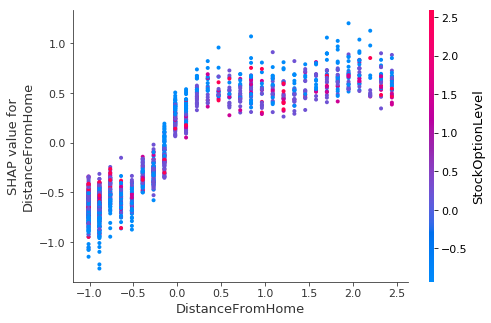

In [29]:
shap.dependence_plot("DistanceFromHome", shap_values, attrition_final)

From this dependency plot, we can see the JobSatisfaction variable might interact with OverTime_yes variable in a way that only when OverTime_yes is yes, employees who have the highest level of job statisfaction are the lest likely to turnover.

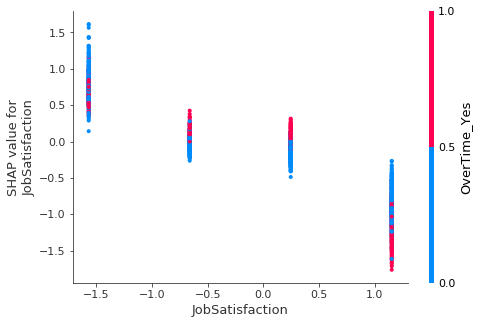

In [30]:
shap.dependence_plot("JobSatisfaction", shap_values, attrition_final)